In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# loading rating dataset
ratings = pd.read_csv(
    "https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv"
)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
# loading movie dataset
movies = pd.read_csv(
    "https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv"
)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
n_ratings = len(ratings)
n_movies = len(ratings["movieId"].unique())
n_users = len(ratings["userId"].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings / n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings / n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average ratings per user: 165.3
Average ratings per movie: 10.37


In [6]:
user_freq = ratings[["userId", "movieId"]].groupby("userId").count().reset_index()
user_freq.columns = ["userId", "n_ratings"]
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [7]:
# Find Lowest and Highest rated movies:
mean_rating = ratings.groupby("movieId")[["rating"]].mean()
# Lowest rated movies
lowest_rated = mean_rating["rating"].idxmin()
movies.loc[movies["movieId"] == lowest_rated]
# Highest rated movies
highest_rated = mean_rating["rating"].idxmax()
movies.loc[movies["movieId"] == highest_rated]
# show number of people who rated movies rated movie highest
ratings[ratings["movieId"] == highest_rated]
# show number of people who rated movies rated movie lowest
ratings[ratings["movieId"] == lowest_rated]

## the above movies has very low dataset. We will use bayesian average
movie_stats = ratings.groupby("movieId")[["rating"]].agg(["count", "mean"])
movie_stats.columns = movie_stats.columns.droplevel()

In [8]:
movie_stats

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429
...,...,...
193581,1,4.000000
193583,1,3.500000
193585,1,3.500000


In [9]:
# Now, we create user-item matrix using scipy csr matrix
from scipy.sparse import csr_matrix


def create_matrix(df):
    N = len(df["userId"].unique())
    M = len(df["movieId"].unique())

    # Map Ids to indices
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))

    # Map indices to IDs
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df["userId"]]
    movie_index = [movie_mapper[i] for i in df["movieId"]]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper


X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)

In [10]:
ratings[ratings["userId"] == 1]

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
227,1,3744,4.0,964980694
228,1,3793,5.0,964981855
229,1,3809,4.0,964981220
230,1,4006,4.0,964982903


In [11]:
X.shape

(9724, 610)

In [12]:
X.toarray()

array([[4. , 0. , 0. , ..., 2.5, 3. , 5. ],
       [0. , 0. , 0. , ..., 2. , 0. , 0. ],
       [4. , 0. , 0. , ..., 2. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [30]:
"""
Find similar movies using KNN
"""
from sklearn.neighbors import NearestNeighbors


def find_similar_movies(movie_id, X, k, metric="euclidean", show_distance=True):
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    # print(movie_vec)
    k += 1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    movie_vec = movie_vec.reshape(1, -1)
    neighbour_dis, neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    # print("Similar film ids:", neighbour)
    print("distance:", neighbour_dis)
    for i in range(0, k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids


movie_titles = dict(zip(movies["movieId"], movies["title"]))

movie_id = 3

similar_ids = find_similar_movies(movie_id, X, k=10, metric="euclidean")
movie_title = movie_titles[movie_id]

print(f"Since you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i], f"(id ={i})")

distance: [[ 0.         22.68810261 22.85278976 22.94013949 22.96736816 23.08679276
  23.13006701 23.23252031 23.23790008 23.27015256 23.28089345]]
Since you watched Grumpier Old Men (1995)
Son in Law (1993) (id =542)
Striptease (1996) (id =762)
Juror, The (1996) (id =79)
Flipper (1996) (id =711)
Beverly Hillbillies, The (1993) (id =419)
Bio-Dome (1996) (id =65)
Kazaam (1996) (id =810)
Angus (1995) (id =700)
Tales from the Crypt Presents: Bordello of Blood (1996) (id =842)
Substitute, The (1996) (id =694)


**t-SNE Visualization** vs **LEE dimensionality reduction** vs **KernelPCA**


distance: [[0.         0.46792656 0.48809054 0.50599582 0.51004773 0.51249056
  0.51789891 0.52050395 0.52801785 0.52813435 0.53420254]]
distance: [[0.         0.46792656 0.48809054 0.50599582 0.51004773 0.51249056
  0.51789891 0.52050395 0.52801785 0.52813435 0.53420254]]
distance: [[0.         0.46792656 0.48809054 0.50599582 0.51004773 0.51249056
  0.51789891 0.52050395 0.52801785 0.52813435 0.53420254]]
[1610, 2115, 1210, 1036, 1580, 1240, 2006, 1196, 648, 1552]


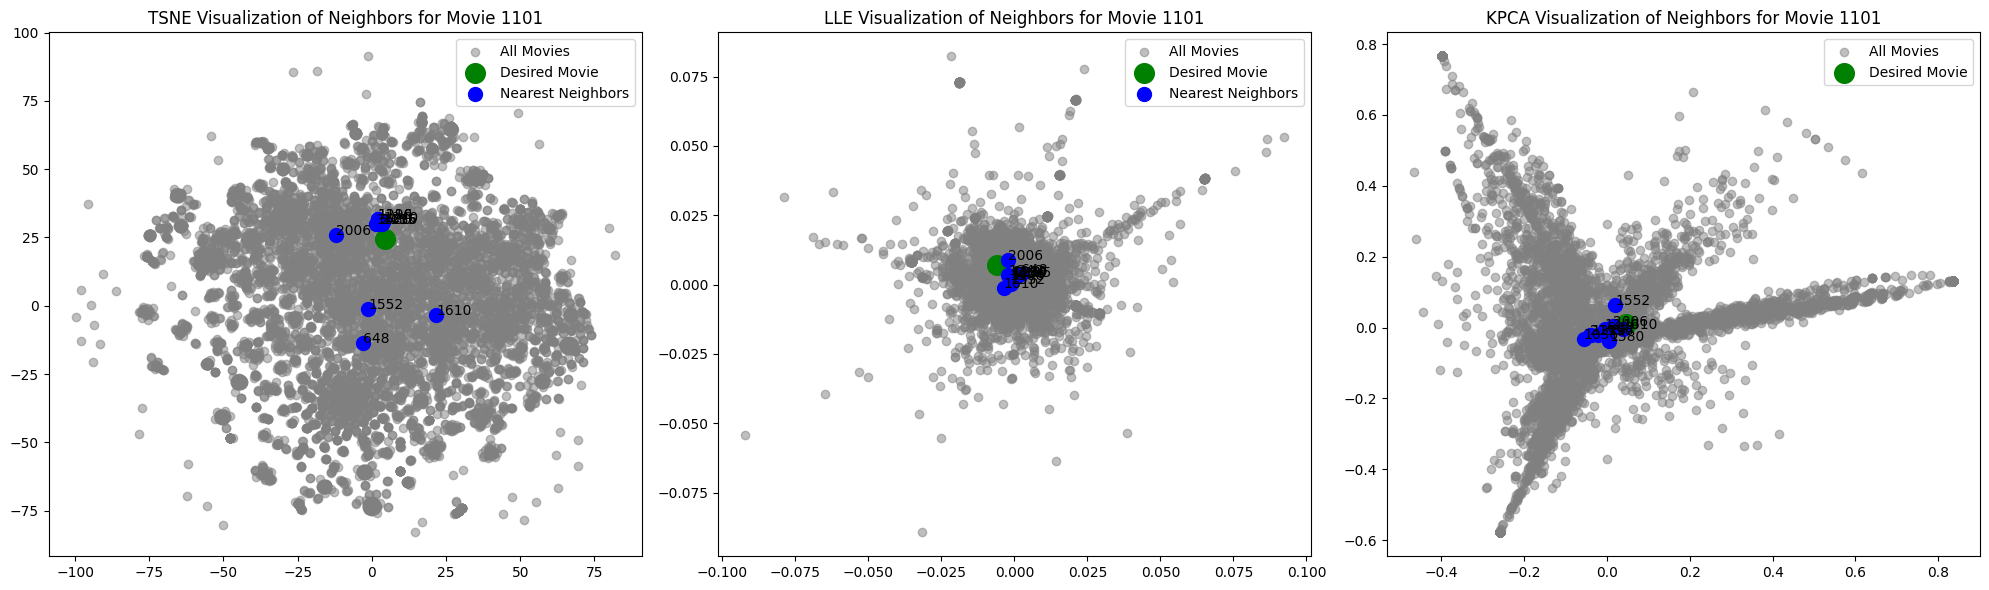

In [34]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import KernelPCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualize_neighbors_lle(movie_id, X, movie_mapper, ax, k=10):
    # Get the index of the movie in the X matrix
    movie_ind = movie_mapper[movie_id]

    # Get the k nearest neighbors
    neighbour_ids = find_similar_movies(movie_id, X, k, metric="cosine")

    # Get the indices of the neighbors in the X matrix
    neighbour_inds = [movie_mapper[n] for n in neighbour_ids]

    # Create an LLE object and fit the data
    lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
    X_lle = lle.fit_transform(X)

    # Plot the LLE visualization
    # plt.figure(figsize=(8, 8))
    ax.scatter(X_lle[:, 0], X_lle[:, 1], c="gray", alpha=0.5, label="All Movies")

    # Highlight the movie and its neighbors
    ax.scatter(
        X_lle[movie_ind, 0],
        X_lle[movie_ind, 1],
        c="green",
        s=200,
        label="Desired Movie",
    )
    ax.scatter(
        X_lle[neighbour_inds, 0],
        X_lle[neighbour_inds, 1],
        c="blue",
        s=100,
        label="Nearest Neighbors",
    )

    # Annotate the neighbors with their movie IDs
    for i, neighbor_id in enumerate(neighbour_ids):
        ax.annotate(
            neighbor_id, (X_lle[neighbour_inds[i], 0], X_lle[neighbour_inds[i], 1])
        )

    ax.set_title("LLE Visualization of Neighbors for Movie {}".format(movie_id))
    ax.legend()
    # plt.show()


def visualize_neighbors_tsne(movie_id, X, movie_mapper, ax, k=10):
    # Get the index of the movie in the X matrix
    movie_ind = movie_mapper[movie_id]

    # Get the k nearest neighbors
    neighbour_ids = find_similar_movies(movie_id, X, k, metric="cosine")

    # Get the indices of the neighbors in the X matrix
    neighbour_inds = [movie_mapper[n] for n in neighbour_ids]

    # Create a TSNE object and fit the data
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)

    # Plot the TSNE visualization
    # plt.figure(figsize=(8, 8))
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c="gray", alpha=0.5, label="All Movies")

    # Highlight the movie and its neighbors
    ax.scatter(
        X_tsne[movie_ind, 0],
        X_tsne[movie_ind, 1],
        c="green",
        s=200,
        label="Desired Movie",
    )
    ax.scatter(
        X_tsne[neighbour_inds, 0],
        X_tsne[neighbour_inds, 1],
        c="blue",
        s=100,
        label="Nearest Neighbors",
    )

    # Annotate the neighbors with their movie IDs
    for i, neighbor_id in enumerate(neighbour_ids):
        ax.annotate(
            neighbor_id, (X_tsne[neighbour_inds[i], 0], X_tsne[neighbour_inds[i], 1])
        )

    ax.set_title("TSNE Visualization of Neighbors for Movie {}".format(movie_id))
    ax.legend()
    # ax.show()


def visualize_neighbors_kpca(movie_id, X, movie_mapper, ax, k=10):
    # Get the k nearest neighbors
    neighbour_ids = find_similar_movies(movie_id, X, k=k, metric="cosine")
    print(neighbour_ids)
    # Get the indices of the neighbors in the X matrix
    neighbour_inds = [movie_mapper[n] for n in neighbour_ids]
    # Get the index of the movie in the X matrix
    movie_ind = movie_mapper[movie_id]

    # Create a KPCA object and fit the data
    kpca = KernelPCA(n_components=2, kernel="cosine", gamma=0.1)
    X_kpca = kpca.fit_transform(X)

    # Plot the KPCA visualization
    # plt.figure(figsize=(8, 8))
    ax.scatter(X_kpca[:, 0], X_kpca[:, 1], c="gray", alpha=0.5, label="All Movies")

    # Highlight the movie and its neighbors
    ax.scatter(
        X_kpca[movie_ind, 0],
        X_kpca[movie_ind, 1],
        c="green",
        s=200,
        label="Desired Movie",
    )
    for i, neighbour_ind in enumerate(neighbour_inds):
        ax.scatter(
            X_kpca[neighbour_ind, 0],
            X_kpca[neighbour_ind, 1],
            c="blue",
            s=100,
        )
        ax.annotate(
            neighbour_ids[i], (X_kpca[neighbour_ind, 0], X_kpca[neighbour_ind, 1])
        )

    ax.set_title("KPCA Visualization of Neighbors for Movie {}".format(movie_id))
    ax.legend()
    # ax.show()


def visualize_neighbors_subplot(movie_id, X, movie_mapper, k=10):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # TSNE
    visualize_neighbors_tsne(movie_id, X, movie_mapper, k=k, ax=axs[0])

    # LLE
    visualize_neighbors_lle(movie_id, X, movie_mapper, k=k, ax=axs[1])

    # KPCA
    visualize_neighbors_kpca(movie_id, X, movie_mapper, k=k, ax=axs[2])

    plt.tight_layout()
    plt.show()


movie_id = 1101
visualize_neighbors_subplot(movie_id, X.toarray(), movie_mapper)

In [63]:
def recommend_movies_for_user(
    user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10
):
    df1 = ratings[ratings["userId"] == user_id]

    if df1.empty:
        print(f"User with ID {user_id} does not exist.")
        return

    movie_id = df1[df1["rating"] == max(df1["rating"])]["movieId"].iloc[0]

    movie_titles = dict(zip(movies["movieId"], movies["title"]))

    similar_ids = find_similar_movies(movie_id, X, k)
    movie_title = movie_titles.get(movie_id, "Movie not found")

    if movie_title == "Movie not found":
        print(f"Movie with ID {movie_id} not found.")
        return

    print(f"Since you watched {movie_title}, you might also like:")
    for i in similar_ids:
        print(movie_titles.get(i, "Movie not found"), "id =", i)

In [72]:
movies[movies["title"] == "Top Gun (1986)"]

,movieId,title,genres
839,1101,Top Gun (1986),Action|Romance


In [71]:
user_id = 100  # Replace with the desired title
recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10)

Since you watched Top Gun (1986), you might also like:
Hunt for Red October, The (1990) id = 1610
Indiana Jones and the Temple of Doom (1984) id = 2115
Star Wars: Episode VI - Return of the Jedi (1983) id = 1210
Die Hard (1988) id = 1036
Men in Black (a.k.a. MIB) (1997) id = 1580
Terminator, The (1984) id = 1240
Mask of Zorro, The (1998) id = 2006
Star Wars: Episode V - The Empire Strikes Back (1980) id = 1196
Mission: Impossible (1996) id = 648
Con Air (1997) id = 1552


In [49]:
user_id = 415  # Replace with the desired user ID
recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10)

Similar film ids: [[ 257  510  277   43  314   46   97 2224  520  507  827]]
Since you watched Pulp Fiction (1994), you might also like:
Silence of the Lambs, The (1991)
Shawshank Redemption, The (1994)
Seven (a.k.a. Se7en) (1995)
Forrest Gump (1994)
Usual Suspects, The (1995)
Braveheart (1995)
Fight Club (1999)
Fargo (1996)
Terminator 2: Judgment Day (1991)
Reservoir Dogs (1992)


# Content-based


In [51]:
movies["combined"] = movies["title"] + " " + movies["genres"]

movies

,movieId,title,genres,combined
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995) Adventure|Animation|Children|...
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji (1995) Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men (1995) Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale (1995) Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II (1995) Comedy
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,Black Butler: Book of the Atlantic (2017) Acti...
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,No Game No Life: Zero (2017) Animation|Comedy|...
9739,193585,Flint (2017),Drama,Flint (2017) Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple (2018) Action|Ani...


In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Compute the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(movies["combined"])

In [54]:
tfidf_matrix.shape

(9742, 9276)

In [57]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
# Construct a reverse map of indices and movie titles in pd.Series
indices = pd.Series(movies.index, index=movies["title"]).drop_duplicates()

In [65]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies[["title", "genres"]].iloc[movie_indices]

In [90]:
title = "Top Gun (1986)"
display(movies[movies["title"].values == title])
get_recommendations(title, cosine_sim)

,movieId,title,genres,combined
839,1101,Top Gun (1986),Action|Romance,Top Gun (1986) Action|Romance


,title,genres
4700,Over the Top (1987),Action|Drama
2914,Woman on Top (2000),Comedy|Romance
8653,Son of a Gun (2014),Action|Crime|Drama
3913,Top Secret! (1984),Comedy
8630,Top Five (2014),Comedy
8612,By the Gun (2014),Crime|Drama|Thriller
2815,F/X (1986),Action|Crime|Thriller
4283,View from the Top (2003),Comedy|Romance
725,Top Hat (1935),Comedy|Musical|Romance
2463,Gun Shy (2000),Comedy
